In [1]:
import pandas as pd

# Load the dataset
file_path = 'dementia_dataset.csv'
dementia_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
dementia_data.head()


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for relevant columns and sort
mmse_data = dementia_data[['Subject ID', 'Group', 'Visit', 'MR Delay', 'MMSE']].copy()
mmse_data.sort_values(by=['Subject ID', 'Visit'], inplace=True)

In [3]:
# Checking for missing values in relevant columns
missing_values = mmse_data.isnull().sum()
missing_values


Subject ID    0
Group         0
Visit         0
MR Delay      0
MMSE          2
dtype: int64

In [4]:
# Checking unique values in 'Group' to ensure consistency
unique_groups = mmse_data['Group'].unique()
unique_groups


array(['Nondemented', 'Demented', 'Converted'], dtype=object)

In [5]:
# Examining the general distribution of visits per subject
visits_per_subject = mmse_data['Subject ID'].value_counts()
visits_per_subject.describe()

count    150.000000
mean       2.486667
std        0.730327
min        2.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: Subject ID, dtype: float64

In [6]:
# Handling the 'Converted' group
# For this analysis, let's keep the 'Converted' group separate to observe the transition
mmse_data_grouped = mmse_data.groupby(['Subject ID', 'Group']).agg({'Visit': 'max'}).reset_index()


In [7]:
# Checking how many subjects are in each group, especially the 'Converted' group
group_counts = mmse_data_grouped['Group'].value_counts()
group_counts

Nondemented    72
Demented       64
Converted      14
Name: Group, dtype: int64

In [8]:
# Ensuring Consistent Time Frames
# Checking the distribution of MR Delay times
mr_delay_distribution = mmse_data['MR Delay'].describe()
mr_delay_distribution

count     373.000000
mean      595.104558
std       635.485118
min         0.000000
25%         0.000000
50%       552.000000
75%       873.000000
max      2639.000000
Name: MR Delay, dtype: float64

In [14]:
# Structuring data for longitudinal analysis
# Creating a pivot table where each row represents a subject and columns represent visits
# This will help in tracking the progression of MMSE scores over different visits

# We limit to a maximum of 5 visits as per the dataset's distribution
max_visits = 5
pivot_columns = ['Visit_' + str(i) for i in range(1, max_visits + 1)]
mmse_pivot = mmse_data.pivot_table(index='Subject ID', columns='Visit', values='MMSE', aggfunc='first')

# Renaming columns for clarity
mmse_pivot.columns = pivot_columns[:len(mmse_pivot.columns)]

# Resetting index to make 'Subject ID' a column
mmse_pivot.reset_index(inplace=True)

# Merging with group data to include the dementia status
mmse_pivot = mmse_pivot.merge(mmse_data_grouped[['Subject ID', 'Group']], on='Subject ID')

# Displaying the structured data
mmse_pivot.head()


,Subject ID,Visit_1,Visit_2,Visit_3,Visit_4,Visit_5,Group
0,OAS2_0001,27.0,30.0,NaN,NaN,NaN,Nondemented
1,OAS2_0002,23.0,28.0,22.0,NaN,NaN,Demented
2,OAS2_0004,28.0,27.0,NaN,NaN,NaN,Nondemented
3,OAS2_0005,28.0,29.0,30.0,NaN,NaN,Nondemented
4,OAS2_0007,28.0,NaN,27.0,27.0,NaN,Demented


In [15]:
# Preparing data for line graphs and box plots
mmse_melted = mmse_pivot.melt(id_vars=['Subject ID', 'Group'], value_vars=pivot_columns, 
                              var_name='Visit', value_name='MMSE')

# Replacing 'Visit_X' with just 'X' for ease of understanding
mmse_melted['Visit'] = mmse_melted['Visit'].str.replace('Visit_', '').astype(int)


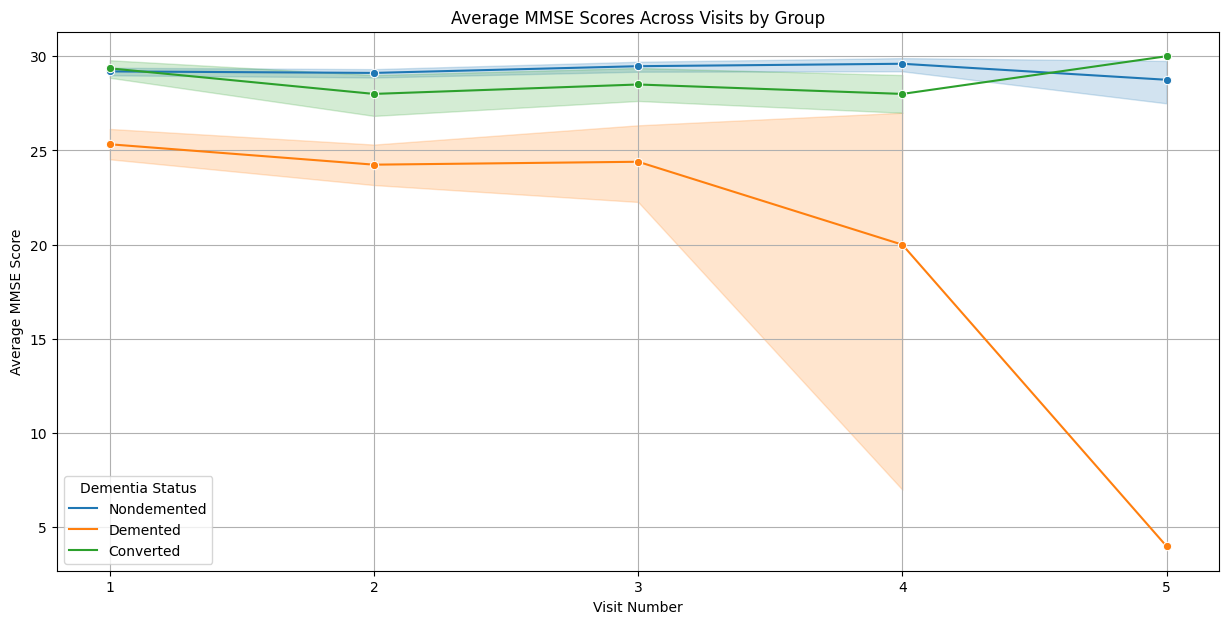

In [18]:
# Creating line graph for each group
plt.figure(figsize=(15, 7))
sns.lineplot(data=mmse_melted, x='Visit', y='MMSE', hue='Group', marker='o')
plt.title('Average MMSE Scores Across Visits by Group')
plt.xlabel('Visit Number')
plt.ylabel('Average MMSE Score')
plt.xticks(range(1, max_visits + 1))
plt.grid(True)
plt.legend(title='Dementia Status')
plt.show()


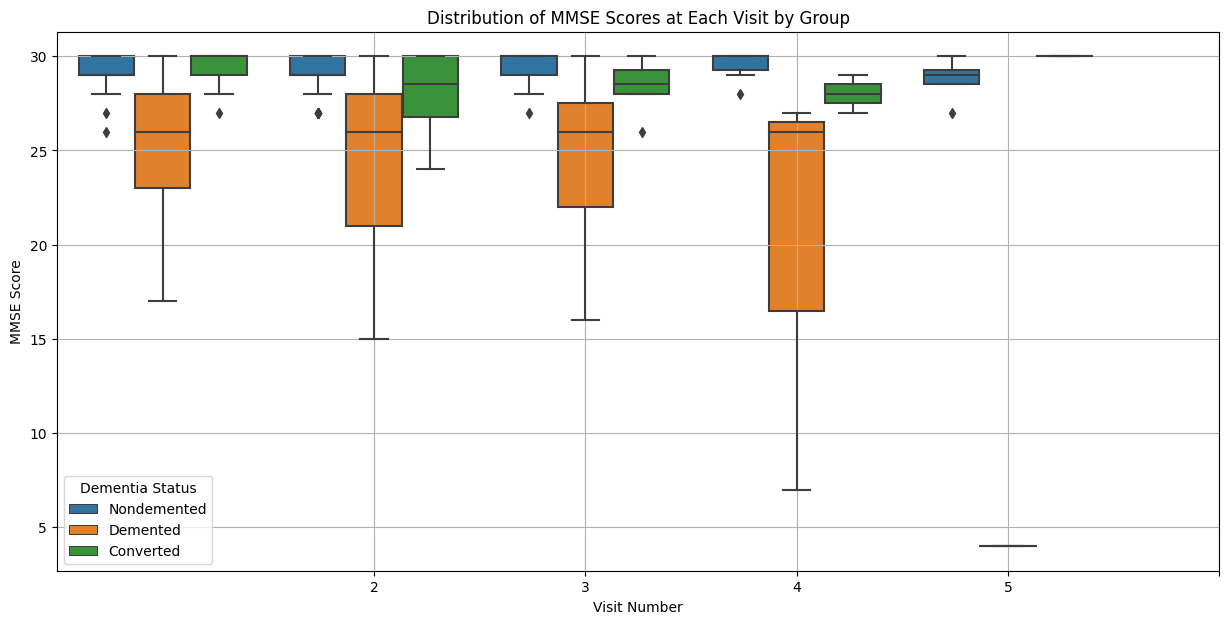

In [17]:
# Creating box plots for each visit
plt.figure(figsize=(15, 7))
sns.boxplot(data=mmse_melted, x='Visit', y='MMSE', hue='Group')
plt.title('Distribution of MMSE Scores at Each Visit by Group')
plt.xlabel('Visit Number')
plt.ylabel('MMSE Score')
plt.xticks(range(1, max_visits + 1))
plt.legend(title='Dementia Status')
plt.grid(True)
plt.show()
